## Introduction to graphs & GNNs with DGL

This notebook serves as a brief introduction to graphs & GNNs using the DGL (https://docs.dgl.ai/index.html) python package. 

In [10]:
import os
os.environ["DGLBACKEND"] = "pytorch"

import dgl
import dgl.data
import dgl.function as fn

import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import defaultdict
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Graphs are defined as a collection of vertices and edges connecting vertices. Here, we will walk through the Zachary's Karate Club network, which we load from the provided dgl datasets.

In [2]:
graph = dgl.data.KarateClubDataset()[0]
graph

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})

The vertices of this graph represent individuals in a karate club--34 in total--and the links represent that two members had interactions outside of the club itself. Over the course of two years as the graph was collected, a conflict arose between two administrators of the club (vertex 33 and 0) that led to the club being split into two.

In this case, the edges are all unweighted--they only exist, as opposed to having some qualifier like distnace. The vertices also do not contain any auxiliary information aside from their label.

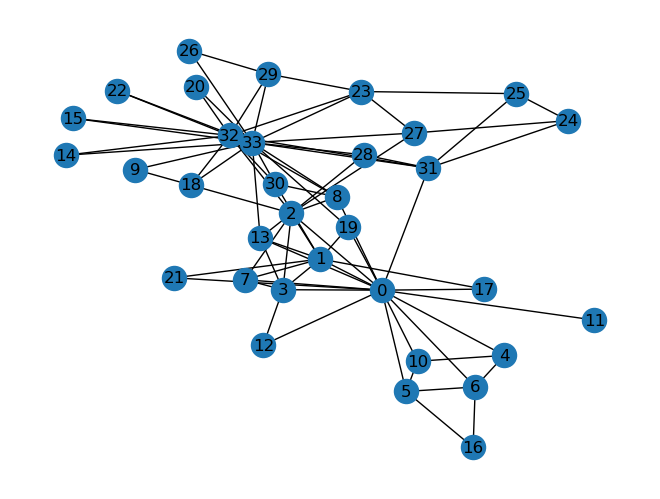

In [3]:
nx.draw(dgl.to_networkx(graph).to_undirected(), with_labels=True)

We will now build a model to predict whether each person would side with one administrator or the other in the split of the group. The base idea of the model we will build here and the core functionality of DGL relates to neural networks.

Neural networks essentially simulate an actual brain. In a neural network, there are several layers with multiple neurons. Generally, the first layer corresponds to the dimension of the data (as a vector), adn the last layer corresponds to the prediction of the neural network. Data is passed through these layers one-by-one, with each neuron trying to calculate weights to best transform the data given to it as an input to the output passed to the next layer. The optimization is done by analyzing the loss, or the predictive performance of the neural network, at the final layer, and this loss is used to adjust weights upstream in the neural network via backpropagation.

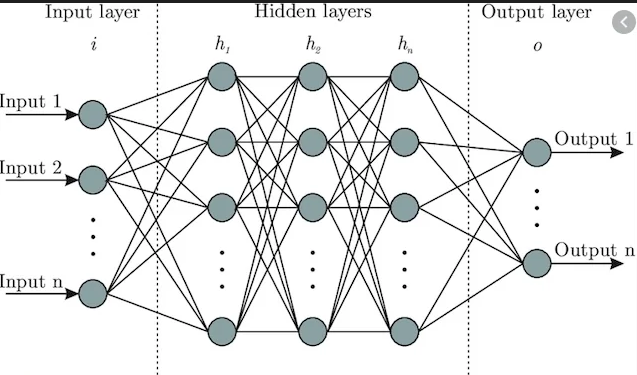

Neural networks traditionally just required some matrix-esque input, but graph neural networks extend upon this formulation to allow the inputation of a graph, with arbitrary connections between nodes that can't be represented easily by a matrix, into a neural network. 

Critical to the idea of graph neural networks is the idea of message passing. In each layer, adjacent vertices pass messages to each other based on their weights, and this message passing is refined as the neural network is trained. Ultimately, this allows layers to both consider weights in prior layers and messages passed to it to better inform outputs to the next layer, allowing for the capturing of more graph-specific features.

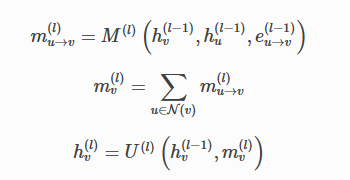

We will now implement basic message passing functionality here--specifically, we will extend a basic linear neural network layer, which takes in input features and transforms them into output features via linear combination of trained weights, and allow the transformation to incorporate the values of neighbors as well.

We will use this layer to create a 2-layer GNN with an intermediate hidden layer to encode features the neural network finds to determine how to classify nodes. 

In [4]:
class GNNLayer(nn.Module):  # base layer of the GNN we will create
    def __init__(self, input_features: int, output_features: int):  # these tell how large the inputs/outputs (number of neurons) of this layer are
        super(GNNLayer, self).__init__()
        # create/store a linear layer within this layer to transform n input features to m output features
        self.linear = nn.Linear(input_features, output_features)
        
    # main logic for training the layer
    def forward(self, g: dgl.DGLGraph, features: torch.tensor):
        # set features for all nodes
        g.ndata["h"] = features
        
        g.update_all(
            fn.copy_u("h", "m"),  # copy h column to the m column for the message components
            fn.mean("m", "h")  # take the mean of the message columns for each node to compute the message
        )
        
        h = g.ndata.pop("h")  # extract out the h column feature
        
        return self.linear(h)  # pass the message through the linear layer
    
class GNN(nn.Module):
    def __init__(self, input_features: int, hidden_layers: int, output_features: int):  # input is the number of in
        super(GNN, self).__init__()
        
        # we will create a 2-layer GNN
        self.layer1 = GNNLayer(input_features, hidden_layers)  # first layer transforms input features to the hidden layer
        self.layer2 = GNNLayer(hidden_layers, output_features)  # second layer transforms the hidden layer to outputs 
        
    def forward(self, g: dgl.DGLGraph, features: torch.tensor):
        h = self.layer1(g, features)  # we first pass in the graph & the features into layer 1
        # we use an activation function to add non-linearity into the neural network
        # this essentially takes in the output of the first layer and performs a function on them to pass to the next layer
        h = torch.relu(h)  
        # we then pass the transformed layer output to the second layer to finally get our output
        h = self.layer2(g, h)
        return h

We will be doing semi-supervised learning to train this node classification model. This means that we will only label 2 nodes -- the two leaders of the karate club -- and we will compute loss/accuracy solely using the predicted labels of these nodes. The model will try to find parameters that best fit these two nodes. We will initialize the inputs with an identity matrix as a starting point. 

In [5]:
classes = [0, 1]  # we are doing a binary classification so we only have 2 classes
hidden_size = 16  # we set our hidden layer size to 16
net = GNN(graph.num_nodes(), hidden_size, len(classes))  # create the GNN with 5 (inputs) -> 16 (hidden) -> 2 (outputs)
inputs = torch.eye(graph.num_nodes())  # initialize the inputs with an identity matrix--each node gets its own unique vector with one 1 and the rest 0s as a starting point

# label our two nodes -- the two leaders of the karate club are in different clubs
labels = torch.tensor([0, 1])
labeled_nodes = torch.tensor([0, 33])

In [6]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)  # create an optimizer to adjust weights w.r.t. computed loss

# run through 100 epochs
for e in range(100):
    # implicitly call forward on the defined model
    logits = net(graph, inputs)
    # evaluate the model to get predictions & calculate the loss based on the predicted labels and the actual labels
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[labeled_nodes], labels)
    
    # zero out the weights
    optimizer.zero_grad()
    # propagate the loss backwards
    loss.backward()
    # try to optimize
    optimizer.step()
    
    print(loss)

tensor(0.6911, grad_fn=<NllLossBackward0>)
tensor(0.6839, grad_fn=<NllLossBackward0>)
tensor(0.6763, grad_fn=<NllLossBackward0>)
tensor(0.6685, grad_fn=<NllLossBackward0>)
tensor(0.6602, grad_fn=<NllLossBackward0>)
tensor(0.6510, grad_fn=<NllLossBackward0>)
tensor(0.6408, grad_fn=<NllLossBackward0>)
tensor(0.6296, grad_fn=<NllLossBackward0>)
tensor(0.6173, grad_fn=<NllLossBackward0>)
tensor(0.6040, grad_fn=<NllLossBackward0>)
tensor(0.5897, grad_fn=<NllLossBackward0>)
tensor(0.5744, grad_fn=<NllLossBackward0>)
tensor(0.5582, grad_fn=<NllLossBackward0>)
tensor(0.5412, grad_fn=<NllLossBackward0>)
tensor(0.5234, grad_fn=<NllLossBackward0>)
tensor(0.5048, grad_fn=<NllLossBackward0>)
tensor(0.4858, grad_fn=<NllLossBackward0>)
tensor(0.4662, grad_fn=<NllLossBackward0>)
tensor(0.4461, grad_fn=<NllLossBackward0>)
tensor(0.4256, grad_fn=<NllLossBackward0>)
tensor(0.4048, grad_fn=<NllLossBackward0>)
tensor(0.3839, grad_fn=<NllLossBackward0>)
tensor(0.3630, grad_fn=<NllLossBackward0>)
tensor(0.34

We view the predictions here. The neural network determined that closer graph proximity to a given leader corresponds to a greater likelihood to join their club after the club fragmented.

In [8]:
# these are our predictions for each node in the graph
preds = torch.argmax(logits, axis=1)
preds

tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

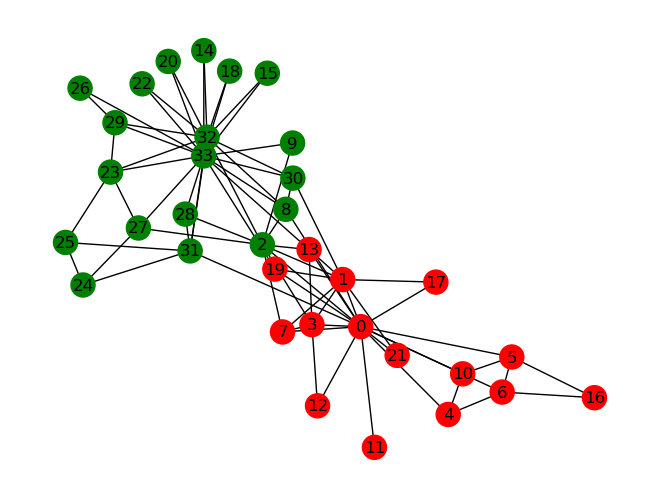

In [9]:
nx.draw(dgl.to_networkx(graph).to_undirected(), with_labels=True, node_color=['red' if x == 0 else 'green' for x in preds])

## Cora graph dataset example

This dataset sourced from dgl itself is the Cora graph dataset. It describes a citation network of various papers, with edges representing citations between one paper and another and vertices representing papers. Each paper has a word count vector as a feature--it essentially describes the most common words in the paper.

Furthermore, each paper has some label representing the category of the paper. Our goal is to build a model to classify a paper based on:

1. its connections (the vertices it is connected to)
2. the word count feature of the paper
3. the word count features of the connected papers

In [64]:
citations = dgl.data.CoraGraphDataset()
g = citations[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


Below, the labels of the papers are shown as well as a subset of the word count vectors.

In [56]:
# labels
pd.Series(g.ndata["label"]).value_counts()

3    818
4    426
2    418
0    351
5    298
1    217
6    180
Name: count, dtype: int64

In [59]:
# features
g.ndata["feat"]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Observe that the data comes with a pre-built train-val-test split. We will train only on the training data and verify on the validation data, which is distinct from the training data to gauge its extensibility beyond its train data. We will finally use the test data as a final measure for the model accuracy.

In [62]:
g.ndata.keys()

dict_keys(['train_mask', 'label', 'val_mask', 'test_mask', 'feat'])

The data does not have any data relating to edges--they are simply unweighted and undirected.

In [63]:
g.edata

{}

The GNN architecture we will follow here is the graph convolutional network (GCN). These are somewhat like a generalization of convolutional neural networks to a graph neural network setting. The essential idea behind the GCN architecture is the use of the Laplacian matrix, which, when inputted into a polynomial, serves as a sort of "filter" that enables message passing.  

Instead of creating this ourselves from scratch, we will use the prebuilt one from DGL to create our neural network. More such prebuilt layers can be found at https://docs.dgl.ai/en/0.9.x/api/python/nn-pytorch.html.

We will create a 2-layer GCN neural network as our model for this problem. The first graph convolution takes the input features into a hidden layer, and the second takes the hidden layer into the number of classes, our final output layer.

In [65]:
from dgl.nn import GraphConv


class GCN(nn.Module):
    def __init__(self, in_feats: int, h_feats: int, num_classes: int):
        # in_feats = number of input features, h_feats = number of features in the hidden layer, num_classes = number of classifications for output
        
        # initialize the overarching nn.Module
        super(GCN, self).__init__()
        # creat the two GCN layers
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    # this function essentially defines the model, taking the inputs forward into outputs
    def forward(self, g, in_feat):
        # g is the DGL graph, which DGL components expect to function
        # in_feat is the input feature
        
        # get the output of the first GCN layer
        h = self.conv1(g, in_feat)
        # map the GCN layer output to an activation funcion to determine whether this "neuron" should be fired/send info to the next layer
        # adds some degree of non-linearity into the output--don't just output the linear combination of the layer
        h = F.relu(h)
        # insert the hidden layer output to the second convolutional layer to get the final classifications
        h = self.conv2(g, h)
        
        # return the final classification--actually probabilistic logits of possible output classifications
        return h

With the neural network framework defined, we will move onto the training loop for our neural network to find the weights that best fit the purpose.

We will use the popular Adam optimizer and run through 100 epochs (i.e., try to optimize the neural networks over the course of 100 iterations).

In [75]:
model = GCN(g.ndata["feat"].shape[1], 16, citations.num_classes)

# use the Adam optimizer to do backpropagation for determining how to adjust weights
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# keep track of the best val/test accuracies
best_val_acc = 0
best_test_acc = 0

# extract key data from the citations graph
features = g.ndata["feat"]
labels = g.ndata["label"]
train_mask = g.ndata["train_mask"]
val_mask = g.ndata["val_mask"]
test_mask = g.ndata["test_mask"]

# run through 100 epochs
for e in range(100):
    # implicitly call forward on the defined model
    logits = model(g, features)

    # Compute predictions for the nodes--just take the most likely prediction
    pred = logits.argmax(1)

    # Compute loss given the predictions and labels
    # Note that you should only compute the losses of the nodes in the training set.
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])

    # Compute accuracy on training/validation/test -- just use % successful / total
    train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
    val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
    test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

    # Save the best validation accuracy and the corresponding test accuracy.
    if best_val_acc < val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc

    # optimize the weights
    
    # zero out the weights
    optimizer.zero_grad()
    # propagate the loss backwards
    loss.backward()
    # try to optimize
    optimizer.step()

    if e % 5 == 0:
        print(
            f"In epoch {e}, loss: {loss:.3f}, val acc: {val_acc:.3f} (best {best_val_acc:.3f}), test acc: {test_acc:.3f} (best {best_test_acc:.3f})"
            )

In epoch 0, loss: 1.946, val acc: 0.120 (best 0.120), test acc: 0.111 (best 0.111)
In epoch 5, loss: 1.891, val acc: 0.470 (best 0.470), test acc: 0.470 (best 0.470)
In epoch 10, loss: 1.808, val acc: 0.616 (best 0.616), test acc: 0.651 (best 0.651)
In epoch 15, loss: 1.695, val acc: 0.610 (best 0.616), test acc: 0.648 (best 0.651)
In epoch 20, loss: 1.559, val acc: 0.652 (best 0.652), test acc: 0.676 (best 0.676)
In epoch 25, loss: 1.401, val acc: 0.686 (best 0.686), test acc: 0.708 (best 0.708)
In epoch 30, loss: 1.228, val acc: 0.704 (best 0.704), test acc: 0.722 (best 0.722)
In epoch 35, loss: 1.050, val acc: 0.722 (best 0.722), test acc: 0.739 (best 0.739)
In epoch 40, loss: 0.877, val acc: 0.740 (best 0.740), test acc: 0.744 (best 0.744)
In epoch 45, loss: 0.720, val acc: 0.748 (best 0.748), test acc: 0.752 (best 0.751)
In epoch 50, loss: 0.583, val acc: 0.762 (best 0.762), test acc: 0.755 (best 0.755)
In epoch 55, loss: 0.470, val acc: 0.766 (best 0.766), test acc: 0.763 (best 0

Here, we can see the final predictions of the model on the test data. Overall, through training, the model was able to get relatively accurate at predicting paper classifications.

In [76]:
# apply the model (with weights trained), take the train data subset and take the most likely prediction (the argmax)
model(g, features)[train_mask].argmax(1)

tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2, 0, 0, 4, 3, 3, 3, 2, 3, 1, 3, 5, 3, 4, 6,
        3, 3, 6, 3, 2, 4, 3, 6, 0, 4, 2, 0, 1, 5, 4, 4, 3, 6, 6, 4, 3, 3, 2, 5,
        3, 4, 5, 3, 0, 2, 1, 4, 6, 3, 2, 2, 0, 0, 0, 4, 2, 0, 4, 5, 2, 6, 5, 2,
        2, 2, 0, 4, 5, 6, 4, 0, 0, 0, 4, 2, 4, 1, 4, 6, 0, 4, 2, 4, 6, 6, 0, 0,
        6, 5, 0, 6, 0, 2, 1, 1, 1, 2, 6, 5, 6, 1, 2, 2, 1, 5, 5, 5, 6, 5, 6, 5,
        5, 1, 6, 6, 1, 5, 1, 6, 5, 5, 5, 1, 5, 1, 1, 1, 1, 1, 1, 1])

## Conclusion


These are just some basic examples of the applications of graph neural networks. In particular, these examples only focused on node classification--classifying vertices of the data based on provided features/edges--but it is also possible to do edge classification (e.g., determine some feature of edges or determine if edges even exist between two vertices) or graph classification (determine some overarching feature of the graph). 

Ultimately, GNNs are well-built to model many phenomena/patterns in data, and with DGL, different model architectures can also be implemented and tested in an easy and efficient manner.

More examples can be found at https://docs.dgl.ai/.